<a href="https://colab.research.google.com/github/gh0st-kid/TimeSeries_Analysis_and_Forecasting/blob/main/TS_model_Prophet(q).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot, plot_cross_validation_metric
import warnings
import logging

In [ ]:
warnings.filterwarnings("ignore")
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [ ]:
def check_version():
  print(f'Pandas версия: {pd.__version__}')
  print(f'Numpy версия: {np.__version__}')
  print(f'Matplotlib версия: {plt.matplotlib.__version__}')
  print(f'Seaborn версия: {sns.__version__}')
  print(f'Scikit-learn версия: {sklearn.__version__}')
  print(f'Prophet версия: {prophet.__version__}')
  print(f'Библиотеки успешно импортированы.')

check_version()

Pandas версия: 2.2.2
Numpy версия: 1.26.4
Matplotlib версия: 3.7.1
Seaborn версия: 0.13.1
Scikit-learn версия: 1.5.2
Prophet версия: 1.1.6
Библиотеки успешно импортированы.


In [ ]:
def load_and_prepare_data(file_path):
  """
  Загружает и подготавливает данные из CSV файла.

  Аргументы:
  file_path : str
      Путь к CSV файлу с данными.

  Возвращает:
  pandas.DataFrame
      Подготовленный датафрейм с данными, где:
    - Удалены пробелы из названий столбцов.
    - Столбец 'year' преобразован в кварталы и удалён.
    - Все числовые столбцы преобразованы в тип float.
    - Данные отсортированы по кварталу.
  """
  df = pd.read_csv(file_path, delimiter=',')
  df.columns = df.columns.str.strip()
  df['year'] = pd.to_datetime(df['year'], format='%m/%d/%Y')
  df['quarter'] = df['year'].dt.to_period('Q')
  numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
  df[numeric_columns] = df[numeric_columns].astype(float)
  df.sort_values('quarter', inplace=True)
  df.drop(columns=['year'], inplace=True)
  df.set_index('quarter', inplace=True)
  df.index = df.index.to_timestamp()
  return df

df = load_and_prepare_data('/content/df.csv')

In [ ]:
df.head(10)

,zan(cfo),zan(szfo),zan(ufo),zan(skfo),zan(pfo),zan(uralfo),zan(sfo),zan(dfo),bezr(cfo),bezr(szfo),...,bezr(sfo),bezr(dfo),srd(cfo),srd(szfo),srd(ufo),srd(skfo),srd(pfo),srd(uralfo),srd(sfo),srd(dfo)
quarter,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19402.5,7169.8,6260.5,3433.2,14150.9,5872.8,8821.8,3049.5,1143.2,524.3,...,1018.8,354.1,20994.4,17568.0,12560.4,10168.8,13275.0,19566.3,12770.6,17202.3
2010-04-01,19675.6,7175.0,6532.1,3714.1,14762.3,5988.3,9167.9,3125.1,944.4,443.9,...,894.2,291.9,25046.3,20140.8,14287.9,12212.4,15659.0,21734.1,14862.1,20543.2
2010-07-01,19895.0,7257.4,6588.1,3703.4,14957.0,6077.4,9461.4,3232.5,900.3,415.4,...,779.5,248.2,23340.4,19058.9,15746.2,13841.7,15731.1,21178.0,14817.9,20412.1
2010-10-01,19892.0,7149.9,6374.2,3703.8,14787.7,6081.8,9110.5,3161.3,855.2,427.5,...,786.9,286.0,29517.9,22802.4,17856.1,17200.4,18629.5,24847.0,17523.5,24927.0
2011-01-01,19722.3,7204.1,6415.3,3670.4,14396.5,6008.9,8923.6,3163.7,943.6,475.3,...,869.3,293.1,22688.4,19065.0,14001.0,11427.8,14494.9,20607.8,14291.7,18913.8
2011-04-01,19974.6,7260.7,6474.7,3832.3,14809.1,6141.6,9166.9,3198.5,836.4,372.5,...,836.5,233.9,27060.0,21536.3,15696.5,13579.3,16737.6,23583.6,16273.5,21702.1
2011-07-01,20342.7,7347.3,6605.1,3901.0,15057.5,6170.0,9315.7,3248.7,828.8,362.3,...,768.8,238.5,25919.8,20866.1,17494.3,15845.5,17440.6,23509.8,16274.1,22692.8
2011-10-01,20188.0,7309.3,6452.0,3762.0,14940.3,6088.5,9127.4,3207.8,821.5,354.6,...,748.3,251.8,32849.0,23565.9,19222.4,19677.1,20433.5,28153.3,19448.0,28099.1
2012-01-01,20106.7,7274.9,6406.9,3732.5,14458.1,6041.3,8898.5,3156.9,784.2,352.1,...,740.8,262.7,24303.0,19997.0,14824.0,12986.0,16201.0,22502.0,15772.0,19449.0


In [ ]:
def prepare_data_prophet(df, variable_name):
    '''
    Подготовка данных для модели Prophet, включая преобразование формата данных.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.

    Возвращает:
        df_prophet : pandas.DataFrame
            Датафрейм, подготовленный для использования в модели Prophet, с
            переименованными столюцами.
    '''
    df_prophet = df.reset_index().rename(columns={'quarter': 'ds',
                                                  variable_name: 'y'})
    return df_prophet

In [ ]:
def train_prophet_model(df_prophet):
    '''
    Обучение модели Prophet на подготовленных данных.

    Аргументы:
        df_prophet : pandas.DataFrame
            Датафрейм с временным рядом, подготовленный для модели Prophet.

    Возвращает:
        model : Prophet
            Обученная модель Prophet.
    '''
    model = Prophet()
    model.fit(df_prophet)
    return model

In [ ]:
def forecast_and_plot_prophet(model, periods=3):
    '''
    Построение прогноза с использованием модели Prophet и визуализация
    рузультатов.

    Аргументы:
        model : Prophet
            Обученная модель Prophet.
        periods : int, optional
            Количество периодов для прогнозирования(по умолчанию 3).

    Возвращает:
        forecast : pandas.DataFrame
            Датафрейм с прогнозируемыми значениями и доверительными интервалами.
    '''
    future = model.make_future_dataframe(periods=periods, freq='Q')
    forecast = model.predict(future)
    fig = model.plot(forecast)
    return forecast

In [ ]:
def evaluate_forecast_prophet(model):
    '''
    Оценка качетва прогноза модели Prophet с использованием кросс-валидации.

    Аргументы:
        model : Prophet
            Обученная модель Prophet.

    Возвращает:
        df_p : pandas.DataFrame
            Датафрейм с метриками оценки качества прогноза.
    '''
    df_cv = cross_validation(model, initial='730 days', period='180 days',
                             horizon='1095 days')
    df_p = performance_metrics(df_cv)
    return df_p

In [ ]:
def prophet_forecast(df, variable_name):
    '''
    Пайплайн для выполнения всех шагов анализа с использованием модели Prophet,
    включая подоготовку данных, обучение, прогнозирование и оценку.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.

    Возвращает:
        forecast : pandas.DataFrame
            Датафрейм с прогнозируемыми значениями.
        df_p : pandas.DataFrame
            Датафрейм с метриками оценки качества прогноза.
    '''
    df_prophet = prepare_data_prophet(df, variable_name)

    # Проверка содержимого df_prophet
    print(df_prophet.head())  # Добавлено для отладки

    model = train_prophet_model(df_prophet)
    forecast = forecast_and_plot_prophet(model)
    df_p = evaluate_forecast_prophet(model)

    # Вывод числовых значений прогнозов
    print('\nЧисловые значения прогнозов:')
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3))

    # Печать результатов оценки качества прогноза
    print('\nОценка качества прогноза')
    print(df_p.head())

          ds  zan(cfo)  zan(szfo)  zan(ufo)  zan(skfo)  zan(pfo)  zan(uralfo)  \
0 2010-01-01   19402.5     7169.8    6260.5     3433.2   14150.9       5872.8   
1 2010-04-01   19675.6     7175.0    6532.1     3714.1   14762.3       5988.3   
2 2010-07-01   19895.0     7257.4    6588.1     3703.4   14957.0       6077.4   
3 2010-10-01   19892.0     7149.9    6374.2     3703.8   14787.7       6081.8   
4 2011-01-01   19722.3     7204.1    6415.3     3670.4   14396.5       6008.9   

   zan(sfo)  zan(dfo)  bezr(cfo)  ...  bezr(sfo)  bezr(dfo)        y  \
0    8821.8    3049.5     1143.2  ...     1018.8      354.1  20994.4   
1    9167.9    3125.1      944.4  ...      894.2      291.9  25046.3   
2    9461.4    3232.5      900.3  ...      779.5      248.2  23340.4   
3    9110.5    3161.3      855.2  ...      786.9      286.0  29517.9   
4    8923.6    3163.7      943.6  ...      869.3      293.1  22688.4   

   srd(szfo)  srd(ufo)  srd(skfo)  srd(pfo)  srd(uralfo)  srd(sfo)  srd(dfo)  
0

  0%|          | 0/14 [00:00<?, ?it/s]


Числовые значения прогнозов:
           ds          yhat    yhat_lower    yhat_upper
48 2021-12-31  46444.892527  44301.053058  48675.261748
49 2022-03-31  53562.355676  51351.533356  55697.683031
50 2022-06-30  52522.129172  50434.544215  54551.798318

Оценка качества прогноза
   horizon           mse         rmse          mae      mape     mdape  \
0 150 days  5.561129e+06  2358.204602  1771.150023  0.053213  0.032591   
1 153 days  5.325804e+06  2307.770303  1722.514832  0.050495  0.032591   
2 155 days  4.243675e+06  2060.018182  1567.122236  0.044000  0.032591   
3 158 days  4.252186e+06  2062.082836  1579.673244  0.044243  0.032591   
4 160 days  3.709855e+06  1926.098463  1440.837019  0.039079  0.022111   

      smape  coverage  
0  0.053190    0.4375  
1  0.050077    0.4375  
2  0.044274    0.4375  
3  0.044520    0.5000  
4  0.039697    0.5000  


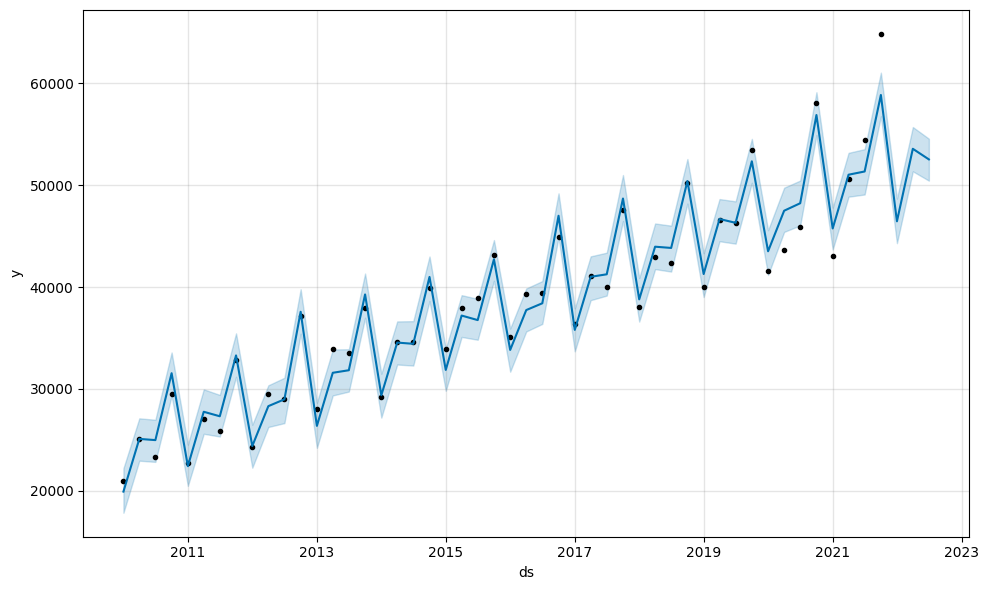

In [ ]:
prophet_forecast(df, 'srd(cfo)')